# Исследование закономерностей, определяющих успех игры

In [1]:
# подключили библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

In [3]:
# изучили информацию о столбцах
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


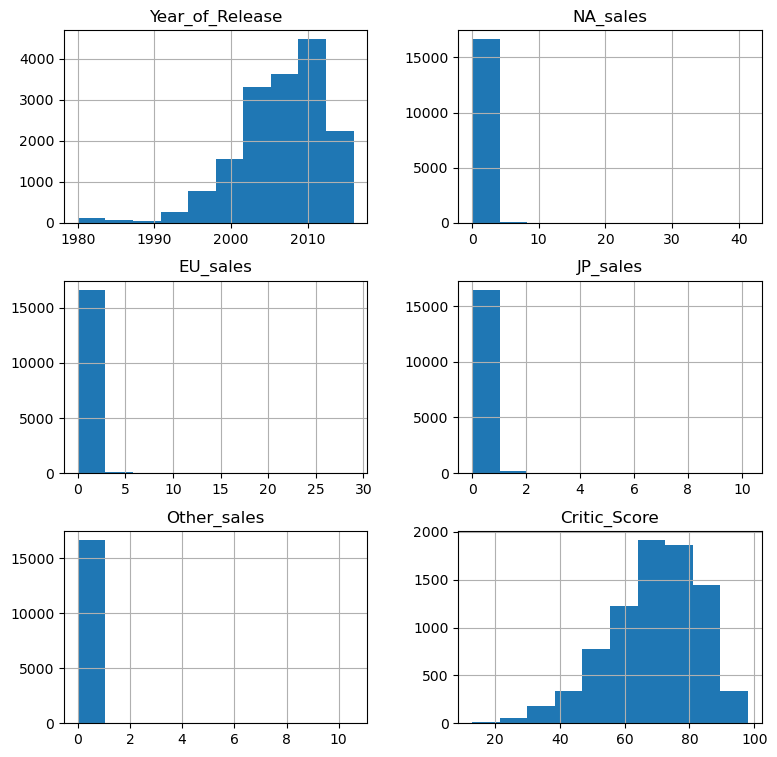

In [4]:
# построили гистограммы для числовых столбцов таблицы
data.hist(figsize=(9, 9))
plt.show()

**Выводы:**
1. Названия столбцов лучше привести к нижнему регистру.
2. В столбцах с названием игры, жанром есть два пропуска, в столбцах с годом релиза есть немного больше пропусков, в столбцах с оценками и рейтингом много пропусков.
3. Столбец год релиза имеет вещественый тип данных, необходимо привести его к целочисленному.
4. Столбец с оценкой пользователя имеет неподходящий тип данных, лучше привести его к числовому типу (float). 
5. В столбцах с продажами большой разброс данных, есть аномально высокие значения.

## Предобработка данных

### Замена названий столбцов

In [5]:
# выполнили переименование столбцов
data.columns = data.columns.str.lower()
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


###  Обработка пропусков

In [6]:
# определили, в каких столбцах есть пропуски
data.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

In [7]:
# посчитали доли пропусков в столбцах
pd.DataFrame(data.isna().mean()*100).sort_values(by=0)[::-1].style.background_gradient('coolwarm')

,0
critic_score,51.319174
rating,40.478612
user_score,40.089740
year_of_release,1.609333
genre,0.011965
name,0.011965
other_sales,0.000000
jp_sales,0.000000
eu_sales,0.000000
na_sales,0.000000


In [8]:
# посмотрели пропуски в названии игры
data[data['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


В строках с пропуском в названии игры есть пропуск в жанре. Таких строки всего две, и так как данные тяжело восстановить, такие строки проще удалить.

In [9]:
# удалили пропуски в названии игры 
data = data.dropna(subset=['name'])

Строки с пропусками в годе релиза восстановить тяжело, заменять медианой некорректно. Если удалять все строки полностью, то можно потерять информацию об оценках и продажах, которая будет полезна в анализе. Пропуски в этом столбце можно заменить на нули.

In [10]:
# заполнили пропуски в годе выпуска 
data['year_of_release'] = data['year_of_release'].fillna(0)

Строки с пропусками в рейтинге ESRB восстановить также тяжело, можно заменить рейтинг заглушкой 'unknown', чтобы оценить влияние того факта, что рейтинг ESRB игры неизвестен, на продажи. Строки с пропусками в оценках критиков и пользователей некорректно заменять медианой, так как доля пропусков в них тоже очень большая. Такие строки можно оставить. 

Доли пропусков в столбцах с оценками и рейтигом похожи, можно предположить, что они появились из-за технической ошибки при сборе информации.

In [11]:
# заменили пропуски в рейтинге на заглушку
data['rating'] = data['rating'].fillna('unknown')
# определили, в каких столбцах остались пропуски
data.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8576
user_score         6699
rating                0
dtype: int64

### Изменение типов данных

В столбце год релиза тип данных - вещественные числа. Год это всегда целое число, нужно привести этот столбец к целочисленному типу.

In [12]:
# привели столбец к целочисленному типу
data['year_of_release'] = data['year_of_release'].astype('int')

В столбце с оценкой пользователя встречается аббревиатура tbd - to be determined - подлежит уточнению, пока не определен. Это строка, а значение оценки пользователя должно быть количественной переменной. Для проведения анализа эти аббревиатуры можно заменить на NaN, а столбец привести к вещественному типу.

In [13]:
# посмотрели количество сокращений в оценке пользователя
print('Количество сокращений: ', data.query('user_score == "tbd"').shape[0])
# привели оценку пользователей к числовому типу
data['user_score'] = pd.to_numeric(data['user_score'], errors='coerce')
data.info()

Количество сокращений:  2424
<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16713 non-null  int64  
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           16713 non-null  object 
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


### Обработка дубликатов

In [14]:
# посмотрели количество полных дубликатов
data.duplicated().sum()

0

В данных нет полных дубликатов

### Добавление суммарных продаж

In [15]:
# добавили столбец с суммой продаж во всех регионах
data['sum_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']
data.head(15)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,unknown,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,unknown,31.38
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,unknown,30.26
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E,29.80
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E,28.91
8,New Super Mario Bros. Wii,Wii,2009,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E,28.32
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,unknown,28.31


**Выводы:**
1. В столбцах с рейтингом, оценками критиков и пользователей большая доля пропусков. Скорее всего, они появились из-за технического сбоя при сборе информации. Для более точного анализа нужно восстановить данные.
2. В столбце с оценкой пользователя встречается аббревиатура tbd - to be determined - подлежит уточнению, пока не определен. Такая оценка не может быть использована в анализе.

## Исследовательский анализ данных

### Исследование выпуска игр по годам

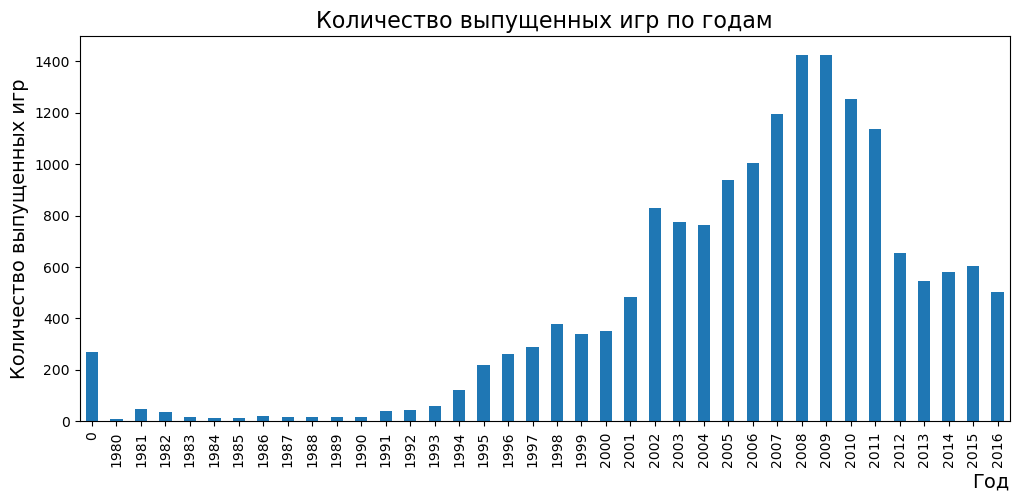

In [16]:
# посмотрели информацию по количеству игр по годам
data.groupby('year_of_release')['name'].count().plot(kind='bar', figsize=(12,5))
plt.xlabel('Год', fontsize=14, loc ='right')
plt.ylabel('Количество выпущенных игр', fontsize=14)
plt.title('Количество выпущенных игр по годам', fontsize=16)
plt.show()

До 1994 выпускалось очень мало игр. Так как разница в количестве выпущенных игр с последующими годами очень большая, то анализировать игры, выпущенные до 1994 года, будет некорректно.

In [17]:
# выбрали нужные года
good_data = data.query('year_of_release >= 1994')

### Исследование суммарных продаж

In [18]:
# посмотрели суммарные продажи по платформам
sum_sales_data = good_data.pivot_table(index=['platform'], values='sum_sales', aggfunc='sum')\
        .sort_values(by='sum_sales', ascending=False).reset_index()
print(sum_sales_data.head(10))

  platform  sum_sales
0      PS2    1233.56
1     X360     961.24
2      PS3     931.34
3      Wii     891.18
4       DS     802.76
5       PS     727.58
6      PS4     314.14
7      GBA     312.88
8      PSP     289.53
9      3DS     257.81


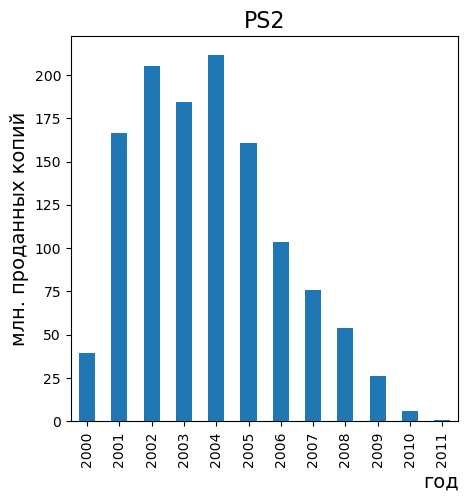

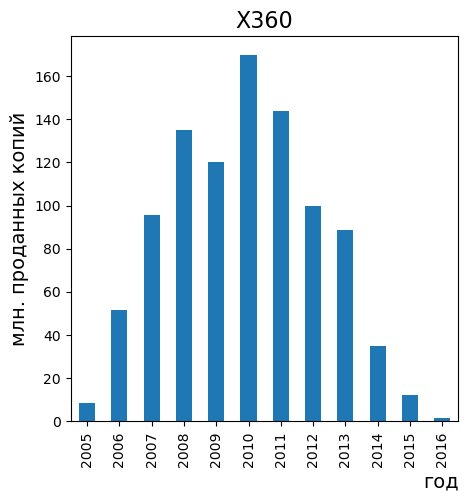

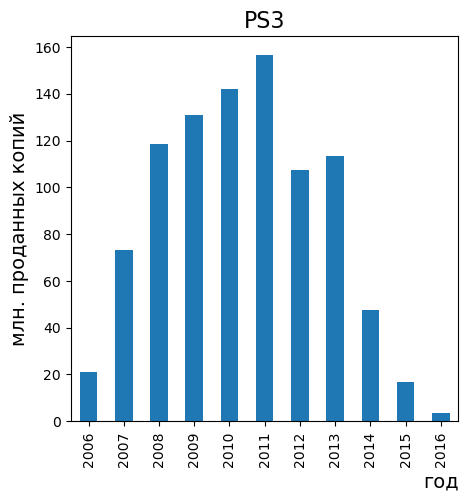

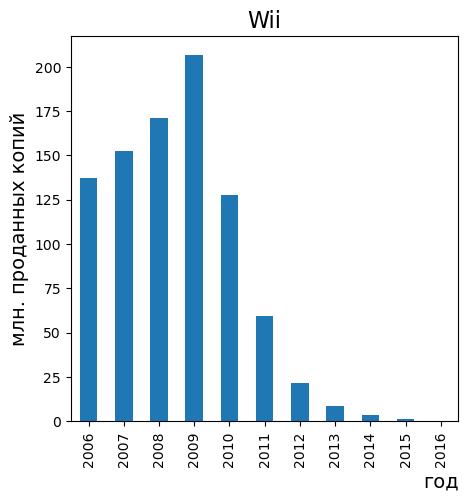

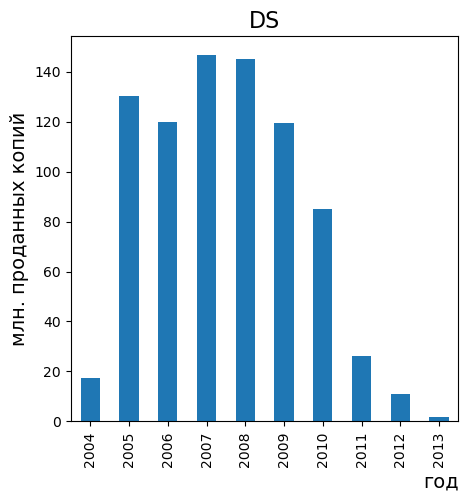

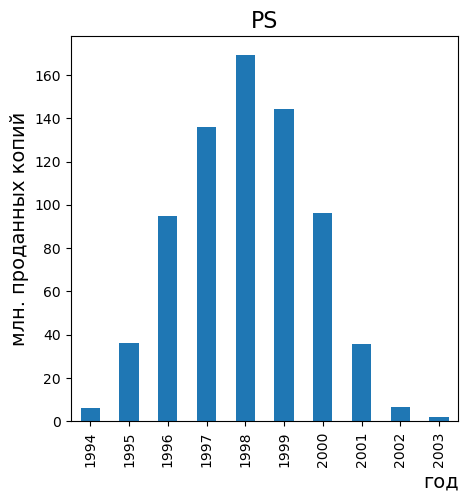

In [19]:
# создали список платформ с наибольшими суммарными продажами
top_sales = sum_sales_data['platform'].head(6).unique()
# построили графики суммы продаж по годам для каждой платформы
for platform in top_sales:
    good_data.query('platform == @platform')\
    .pivot_table(index=['year_of_release'], values='sum_sales', aggfunc='sum')\
    .plot(kind='bar', figsize=(5,5), legend=False)
    plt.title(platform, fontsize=16)
    plt.ylabel('млн. проданных копий', fontsize=14)
    plt.xlabel('год', fontsize=14, loc ='right')
plt.show()

По гистограмме видно, что обычно платформы "живут" десять лет, затем они становятся не актуальными, и им на смену приходят другие платформы.

Для построения прогноза нужны актуальные данные, поэтому в дальнейшем в анализе будут использваться только данные за последние 5 лет.

In [20]:
# выбрали данные за последние 5 лет
good_data2 = data.query('year_of_release >= 2012')
# выявили платформы-лидеры в продажах
top_sales = (good_data2.pivot_table(index=['platform'], values='sum_sales', aggfunc='sum')
             .sort_values(by='sum_sales', ascending=False).reset_index().head(10)['platform'])
top_sales

0     PS4
1     PS3
2    X360
3     3DS
4    XOne
5    WiiU
6      PC
7     PSV
8     Wii
9      DS
Name: platform, dtype: object

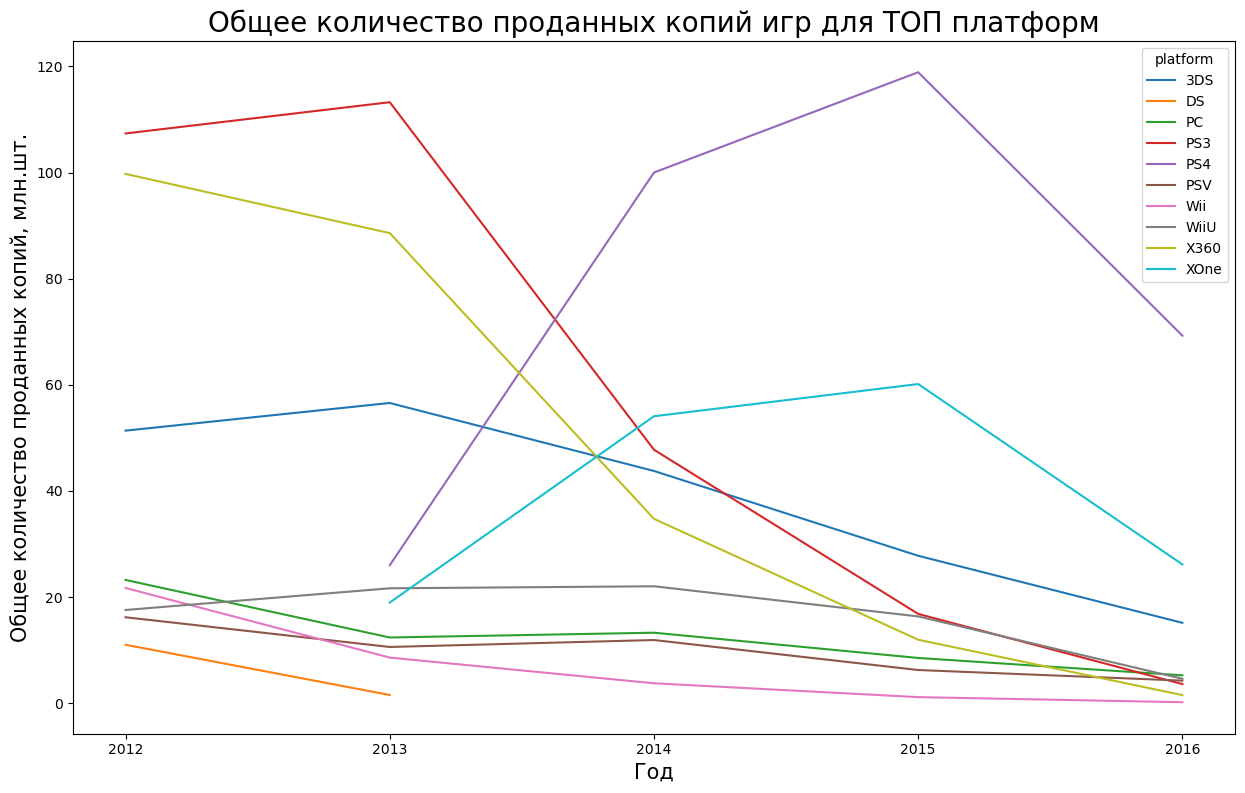

In [21]:
# построили графики продаж для лидеров
good_data2.query('platform in @top_sales').pivot_table(index=['year_of_release'], columns=['platform'], \
        values='sum_sales', aggfunc='sum').reset_index().\
        plot(x='year_of_release', figsize=(15,9))
plt.title('Общее количество проданных копий игр для ТОП платформ', fontsize=20)
plt.xlabel('Год', fontsize=15)
plt.ylabel('Общее количество проданных копий, млн.шт.', fontsize=15)
plt.xticks(np.arange(2012, 2016+1, 1.0))
plt.show;

За последние 5 лет больше всего продаж были по платформам: PS4, PS3, X360, 3DS, XOne, WiiU, PC, PSV, Wii, DS. 
За 2016 год данные не полные. На 2015 год по продажам лидируют XOne, PS4, 3DS. 

По графику видно, что продажи по всем платформам из топа, кроме XOne и PS4, с каждым годом снижаются и их "срок жизни" подходит к концу. А продажи по платформам XOne и PS4, которые появились только в 2013 году, наоборот, с каждым годом растут. XOne и PS4 являются потенциально прибыльными.

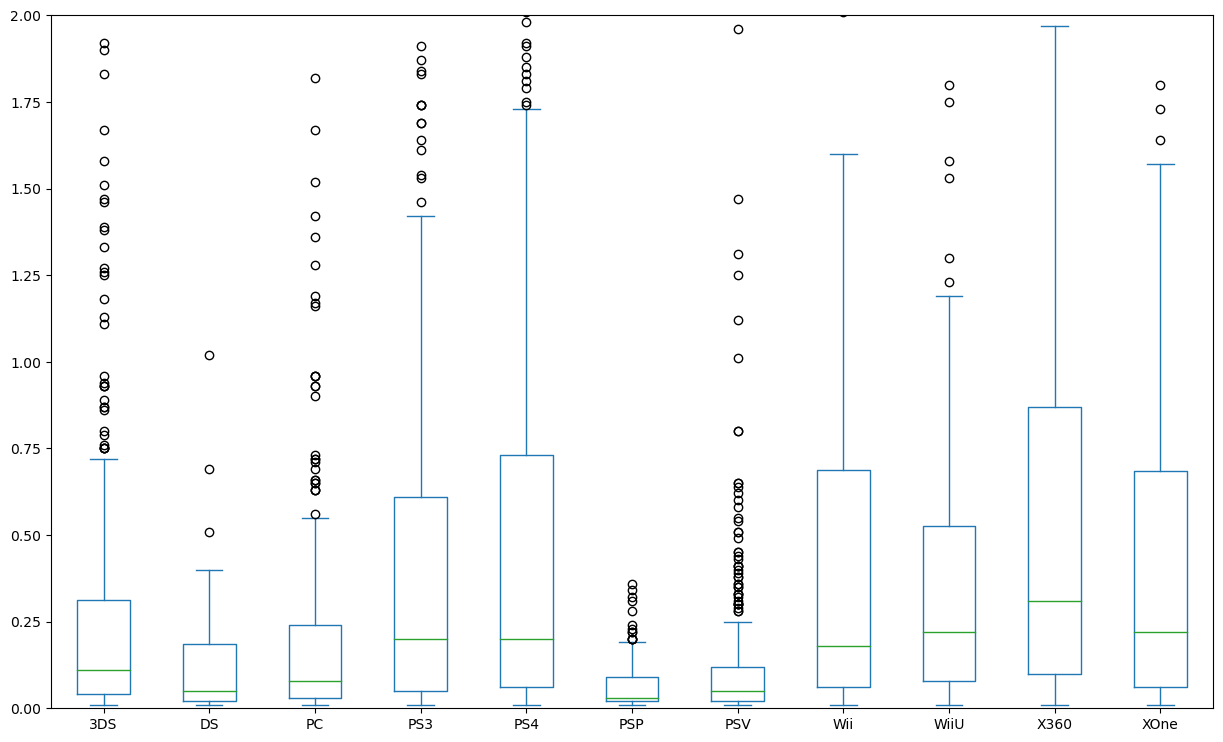

In [22]:
# сделали сводную по суммам продаж кажой игры по каждой платформе и построили диаграммы размаха
good_data2.pivot_table(index='name', columns='platform', values='sum_sales', aggfunc='sum').plot(kind='box', figsize=(15,9))
plt.ylim(0,2)
plt.show()

Практически на всех диаграммах размаха есть аномально высокие значения. Это значит, что на всех платформах выпускались игры с рекордными продажами.

По диаграммам размаха можно выделить категорию портативных консолей (3DS, DS, PSP, PSV) и ПК. Ящики и медианные значения продаж этой категории заметно ниже, чем у стационарных консолей (PS3, PS4, Wii, WiiU X360 и XOne). Значит, игры на стационарные консоли покупают значительно чаще, чем на портативные и ПК.

### Исследование влияния оценок на продажи

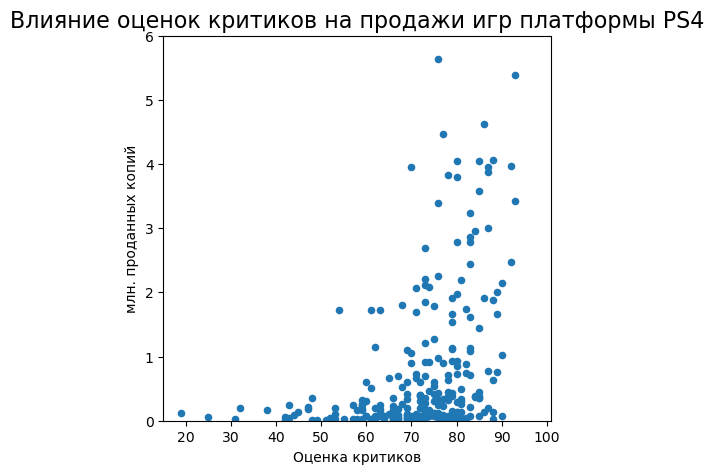

In [23]:
# выбрали самую популярную платформу с 2015 года для анализа оценок
ps4_data = good_data2.query('platform == "PS4"')
# построили диаграмму рассеяния
ps4_data.plot(x='critic_score', y='sum_sales', kind='scatter', figsize=(5,5))
plt.title('Влияние оценок критиков на продажи игр платформы PS4', fontsize=16)
plt.xlabel('Оценка критиков', fontsize=10)
plt.ylabel('млн. проданных копий', fontsize=10)
plt.ylim(0,6)
plt.show()

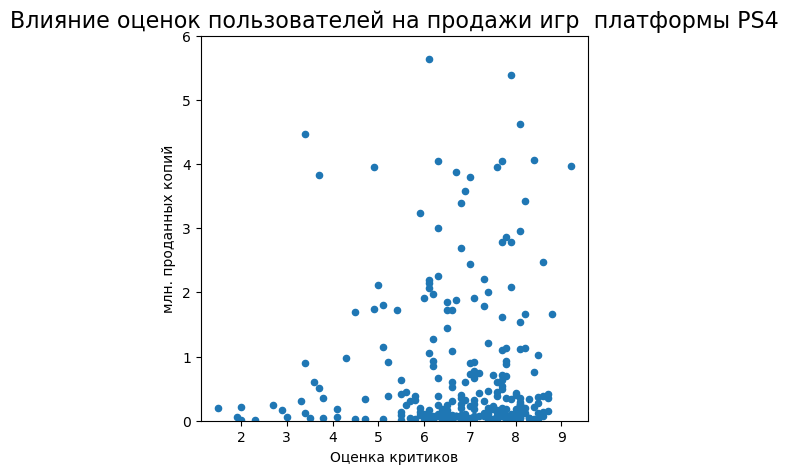

In [24]:
# построили диаграмму рассеяния
ps4_data.plot(x='user_score', y='sum_sales', kind='scatter', figsize=(5,5))
plt.title('Влияние оценок пользователей на продажи игр  платформы PS4', fontsize=16)
plt.xlabel('Оценка критиков', fontsize=10)
plt.ylabel('млн. проданных копий', fontsize=10)
plt.ylim(0,6)
plt.show()

In [25]:
# посчитали коэффициенты корреляции
print('Коэффициент корреляции суммы продаж и оценки критиков:', round(ps4_data['sum_sales'].corr(ps4_data['critic_score']),2))
print('Коэффициент корреляции суммы продаж и оценки пользователей:', round(ps4_data['sum_sales'].corr(ps4_data['user_score']),2))

Коэффициент корреляции суммы продаж и оценки критиков: 0.41
Коэффициент корреляции суммы продаж и оценки пользователей: -0.03


Между оценкой критиков и продажами платформы PS4 существует средняя положительная линейная связь. Т.е. в общем случае чем выше оценка критиков, тем больше продаж. Между оценкой пользователей и продажами платформы PS4 такая связь практически не выражена. Т.е. оценка пользователей не влияет на продажи игр платформы PS4.

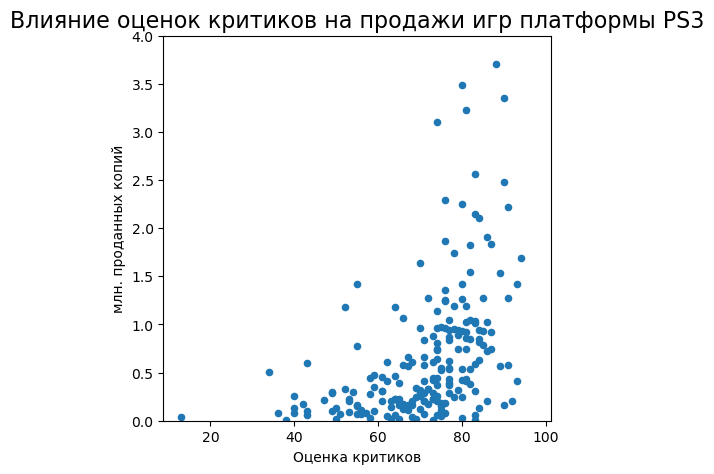

In [26]:
# посмотрели на корреляцию оценки критиков с продажами на платформе PS3
ps3_data = good_data2.query('platform == "PS3"')
# построили диаграмму рассеяния
ps3_data.plot(x='critic_score', y='sum_sales', kind='scatter', figsize=(5,5))
plt.title('Влияние оценок критиков на продажи игр платформы PS3', fontsize=16)
plt.xlabel('Оценка критиков', fontsize=10)
plt.ylabel('млн. проданных копий', fontsize=10)
plt.ylim(0,4)
plt.show()

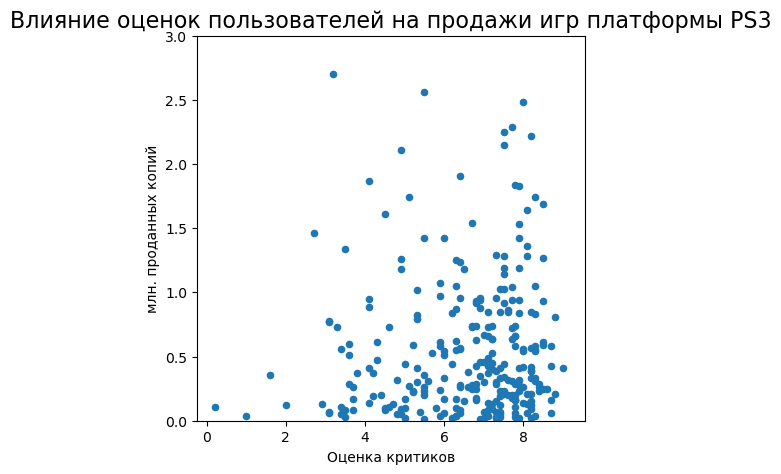

In [27]:
# посмотрели на корреляцию оценки пользователей с продажами на платформе PS3
ps3_data.plot(x='user_score', y='sum_sales', kind='scatter', figsize=(5,5))
plt.title('Влияние оценок пользователей на продажи игр платформы PS3', fontsize=16)
plt.xlabel('Оценка критиков', fontsize=10)
plt.ylabel('млн. проданных копий', fontsize=10)
plt.ylim(0,3)
plt.show()

In [28]:
# посчитали коэффициенты корреляции
print('Коэффициент корреляции суммы продаж и оценки критиков:', round(ps3_data['sum_sales'].corr(ps3_data['critic_score']),2))
print('Коэффициент корреляции суммы продаж и оценки пользователей:', round(ps3_data['sum_sales'].corr(ps3_data['user_score']),2))

Коэффициент корреляции суммы продаж и оценки критиков: 0.33
Коэффициент корреляции суммы продаж и оценки пользователей: -0.01


Ситуация похожа на влияние оценок на продажи игр платформы PS3, но связь продаж с оценками критиков немного слабее.

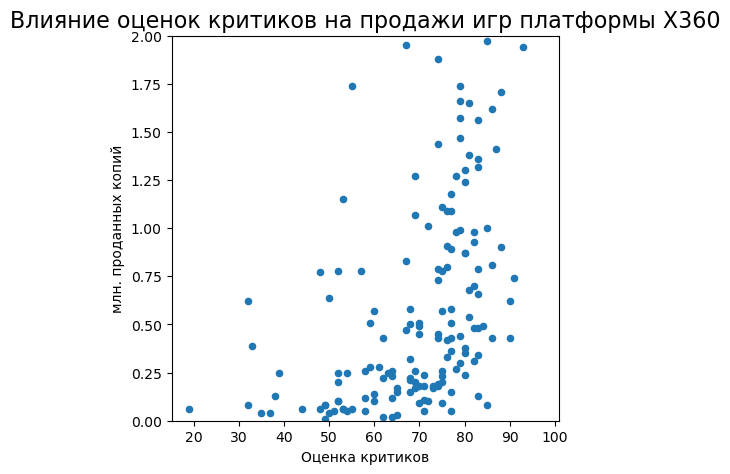

In [29]:
# посмотрели на корреляцию оценки критиков с продажами на платформе X360
x360_data = good_data2.query('platform == "X360"')
# построили диаграмму рассеяния
x360_data.plot(x='critic_score', y='sum_sales', kind='scatter', figsize=(5,5))
plt.title('Влияние оценок критиков на продажи игр платформы X360', fontsize=16)
plt.xlabel('Оценка критиков', fontsize=10)
plt.ylabel('млн. проданных копий', fontsize=10)
plt.ylim(0,2)
plt.show()

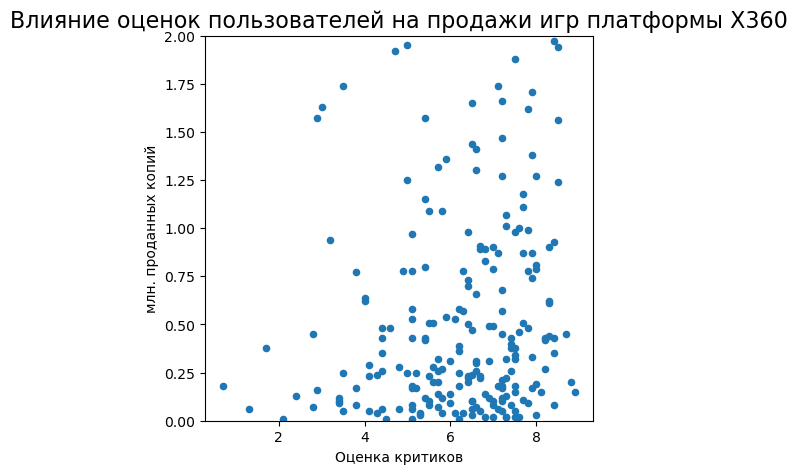

In [30]:
# посмотрели на корреляцию оценки пользователей с продажами на платформе X360
x360_data.plot(x='user_score', y='sum_sales', kind='scatter', figsize=(5,5))
plt.title('Влияние оценок пользователей на продажи игр платформы X360', fontsize=16)
plt.xlabel('Оценка критиков', fontsize=10)
plt.ylabel('млн. проданных копий', fontsize=10)
plt.ylim(0,2)
plt.show()

In [31]:
# посчитали коэффициенты корреляции
print('Коэффициент корреляции суммы продаж и оценки критиков:', round(x360_data['sum_sales'].corr(x360_data['critic_score']),2))
print('Коэффициент корреляции суммы продаж и оценки пользователей:', round(x360_data['sum_sales'].corr(x360_data['user_score']),2))

Коэффициент корреляции суммы продаж и оценки критиков: 0.36
Коэффициент корреляции суммы продаж и оценки пользователей: 0.01


И на платформе X360 ситуация похожа.

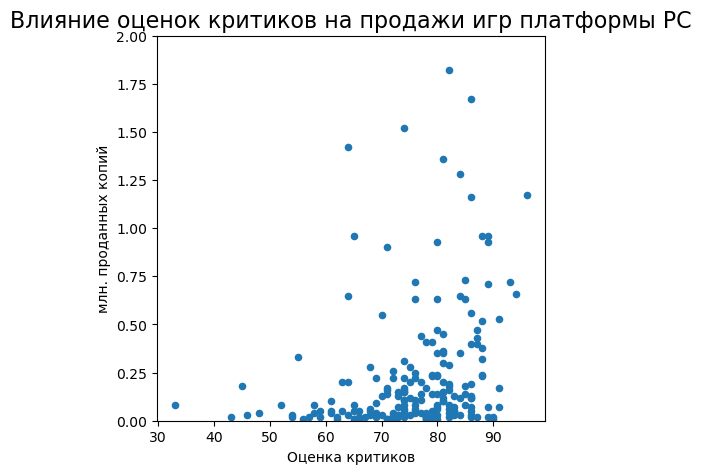

In [32]:
# посмотрели на корреляцию оценки критиков с продажами на платформе PC
pc_data = good_data2.query('platform == "PC"')
# построили диаграмму рассеяния
pc_data.plot(x='critic_score', y='sum_sales', kind='scatter', figsize=(5,5))
plt.title('Влияние оценок критиков на продажи игр платформы PC', fontsize=16)
plt.xlabel('Оценка критиков', fontsize=10)
plt.ylabel('млн. проданных копий', fontsize=10)
plt.ylim(0,2)
plt.show()

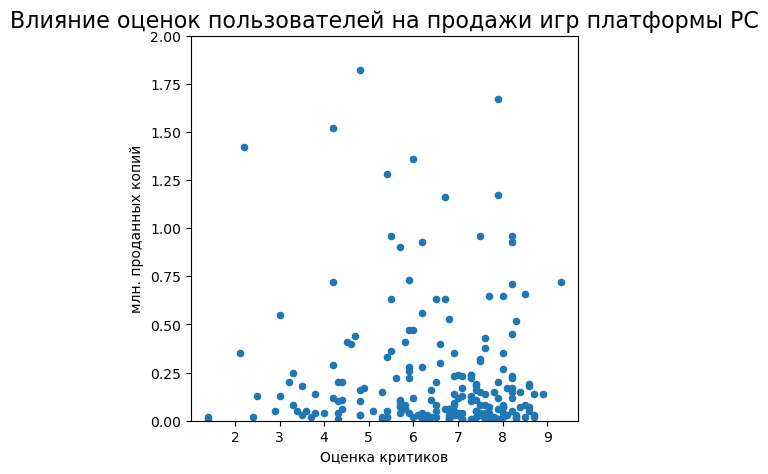

In [33]:
# посмотрели на корреляцию оценки пользователей с продажами на платформе 3DS
pc_data.plot(x='user_score', y='sum_sales', kind='scatter', figsize=(5,5))
plt.title('Влияние оценок пользователей на продажи игр платформы PC', fontsize=16)
plt.xlabel('Оценка критиков', fontsize=10)
plt.ylabel('млн. проданных копий', fontsize=10)
plt.ylim(0,2)
plt.show()

In [34]:
# посчитали коэффициенты корреляции
print('Коэффициент корреляции суммы продаж и оценки критиков:', round(pc_data['sum_sales'].corr(pc_data['critic_score']),2))
print('Коэффициент корреляции суммы продаж и оценки пользователей:', round(pc_data['sum_sales'].corr(pc_data['user_score']),2))

Коэффициент корреляции суммы продаж и оценки критиков: 0.24
Коэффициент корреляции суммы продаж и оценки пользователей: -0.12


И здесь ситуация похожа.
В целом, можно сказать, что между оценками критиков и продажами существует достаточно сильная зависимость. Т.е. чем выше оценка критиков, тем больше продаж. А вот между оценками пользователей и продажами такой связи практически нет.

### Исследование продаж игр по жанрам

In [35]:
# посмотрели долю жанров по количеству и по продажам
jenres = good_data2.pivot_table(index='genre', values='sum_sales', aggfunc=['count', 'sum', 'mean']).reset_index()
jenres.columns = ['genre', 'count', 'sum', 'mean']
jenres.sort_values('mean', ascending=False)

,genre,count,sum,mean
8,Shooter,235,304.73,1.296723
4,Platform,85,61.00,0.717647
10,Sports,268,181.07,0.675634
7,Role-Playing,370,192.80,0.521081
6,Racing,115,53.50,0.465217
3,Misc,192,85.04,0.442917
9,Simulation,80,35.12,0.439000
0,Action,1031,441.12,0.427856
2,Fighting,109,44.49,0.408165
11,Strategy,71,13.34,0.187887


Cреднее показывает среднее количество проданных копий (млн. шт.) одной игры данного жанра. Можно заметить, что есть жанры, которые продаются лучше других.

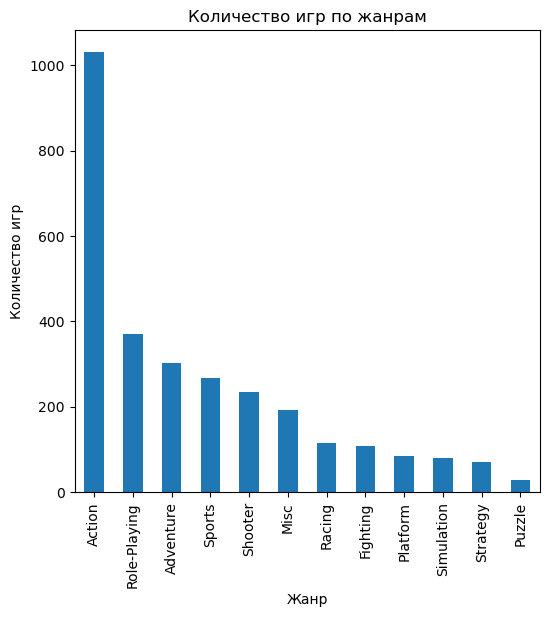

In [36]:
# построили график с количеством игр по каждому жанру
good_data2.pivot_table(index='genre', values='name', aggfunc='count')\
.sort_values('name', ascending=False)\
.plot(kind='bar', legend=None, figsize=(6,6), subplots=True)
plt.ylabel('Количество игр')
plt.xlabel('Жанр')
plt.title('Количество игр по жанрам')
plt.show()

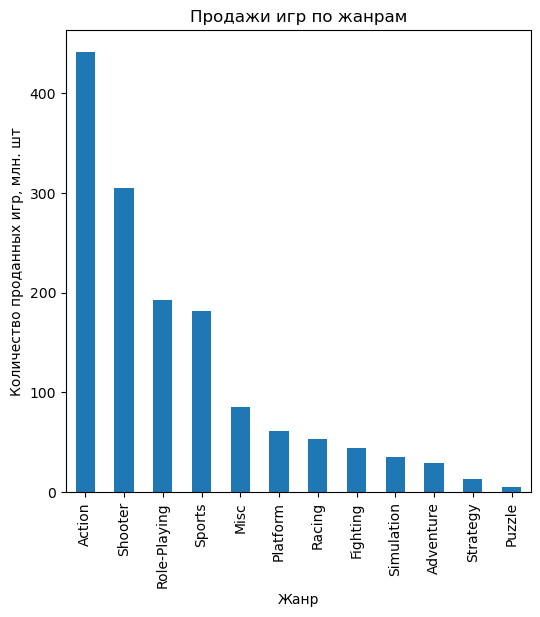

In [37]:
# построили график с продажами игр по каждому жанру
good_data2.pivot_table(index='genre', values='sum_sales', aggfunc='sum')\
.sort_values('sum_sales', ascending=False)\
.plot(kind='bar', legend=None, figsize=(6,6), subplots=True)
plt.ylabel('Количество проданных игр, млн. шт')
plt.xlabel('Жанр')
plt.title('Продажи игр по жанрам')
plt.show()

У игр жанров Adventure, Strategy, Puzzle среднее количество проданных копий существенно меньше. Значит, игры этих жанров покупают реже. И, наоборот, чаще покупают игры жанров Sports, Shooter, Platform.

Самые покупаемые жанры: Action, Sports, Shooter. Причем, в жанре Sports и Shooter среднее количество проданных копий на игру значительно выше доли, значит эти игры очень хорошо продаются.

**Выводы:**

- До 1994 выпускалось очень мало игр.
- Обычно игровые платформы "живут" десять лет, затем они становятся не актуальными, и им на смену приходят другие.
- За последние несколько лет больше всего продаж было по платформам: PS3, PS4, X360, 3DS, XOne, WiiU, PC, PSV, Wii, DS. На 2015 год по продажам лидируют XOne, PS4, 3DS.
- Продажи по платформам XOne и PS4, которые появились только в 2013 году, с каждым годом растут. XOne и PS4 являются потенциально прибыльными.
- Игры для стационарных консолей (PS3, PS4, Wii, WiiU X360 и XOne) покупают гораздо чаще, чем на портативные (3DS, DS, PSP, PSV) и ПК.
- Чем выше оценка критиков, тем больше продаж игры. А вот между оценками пользователей и продажами такой связи практически нет.
- У игр жанров Adventure, Strategy, Puzzle среднее количество проданных копий существенно меньше. Значит, игры этих жанров покупают реже. 
- Чаще покупают игры жанров Sports, Shooter, Platform. Самые покупаемые жанры: Action, Sports, Shooter. Причем, в жанре Sports и Shooter среднее количество проданных копий на игру значительно выше доли, значит эти игры очень хорошо продаются.

## Портрет пользователя каждого региона

### Самые популярные платформы

In [38]:
# определили топ-5 платформ в Северной Америке
na_sales = good_data2.pivot_table(index='platform', values='na_sales', aggfunc='sum')\
.reset_index().sort_values('na_sales', ascending=False)
na_sales['sales_share, %'] = round(na_sales['na_sales']*100/sum(na_sales['na_sales']),2)
na_sales.head()

,platform,na_sales,"sales_share, %"
9,X360,140.05,23.70
4,PS4,108.74,18.40
3,PS3,103.38,17.49
10,XOne,93.12,15.76
0,3DS,55.31,9.36


In [39]:
# определили топ-5 платформ в Европе
eu_sales = good_data2.pivot_table(index='platform', values='eu_sales', aggfunc='sum')\
.reset_index().sort_values('eu_sales', ascending=False)
eu_sales['sales_share, %'] = round(eu_sales['eu_sales']*100/sum(eu_sales['eu_sales']),2)
eu_sales.head()

,platform,eu_sales,"sales_share, %"
4,PS4,141.09,27.84
3,PS3,106.86,21.08
9,X360,74.52,14.70
10,XOne,51.59,10.18
0,3DS,42.64,8.41


In [40]:
# определили топ-5 платформ в Японии
jp_sales = good_data2.pivot_table(index='platform', values='jp_sales', aggfunc='sum')\
.reset_index().sort_values('jp_sales', ascending=False)
jp_sales['sales_share, %'] = round(jp_sales['jp_sales']*100/sum(jp_sales['jp_sales']),2)
jp_sales.head()

,platform,jp_sales,"sales_share, %"
0,3DS,87.79,45.59
3,PS3,35.29,18.32
6,PSV,21.04,10.93
4,PS4,15.96,8.29
8,WiiU,13.01,6.76


В Северной Америке и Европе предпочтения по платформам похожи: в топе X360, XOne, PS3, PS4, 3DS.
В Японии распределение продаж по платформам совсем другое: в топе также 3DS и PS3, но еще есть PSV, PSP и WiiU.

### Самые популярные жанры

In [41]:
# определили топ-5 жанров в Северной Америке
na_sales = good_data2.pivot_table(index='genre', values='na_sales', aggfunc='sum')\
.reset_index().sort_values('na_sales', ascending=False)
na_sales['sales_share, %'] = round(na_sales['na_sales']*100/sum(na_sales['na_sales']),2)
na_sales.head()

,genre,na_sales,"sales_share, %"
0,Action,177.84,30.09
8,Shooter,144.77,24.50
10,Sports,81.53,13.80
7,Role-Playing,64.00,10.83
3,Misc,38.19,6.46


In [42]:
# определили топ-5 жанров в Европе
eu_sales = good_data2.pivot_table(index='genre', values='eu_sales', aggfunc='sum')\
.reset_index().sort_values('eu_sales', ascending=False)
eu_sales['sales_share, %'] = round(eu_sales['eu_sales']*100/sum(eu_sales['eu_sales']),2)
eu_sales.head()

,genre,eu_sales,"sales_share, %"
0,Action,159.34,31.44
8,Shooter,113.47,22.39
10,Sports,69.09,13.63
7,Role-Playing,48.53,9.58
6,Racing,27.29,5.38


In [43]:
# определили топ-5 жанров в Японии
jp_sales = good_data2.pivot_table(index='genre', values='jp_sales', aggfunc='sum')\
.reset_index().sort_values('jp_sales', ascending=False)
jp_sales['sales_share, %'] = round(jp_sales['jp_sales']*100/sum(jp_sales['jp_sales']),2)
jp_sales.head()

,genre,jp_sales,"sales_share, %"
7,Role-Playing,65.44,33.98
0,Action,52.80,27.42
3,Misc,12.86,6.68
9,Simulation,10.41,5.41
2,Fighting,9.44,4.90


Топ-5 жанров в Северной Америке и Европе существенно не отличаются: в топе Action, Shooter, Sports, Role-Playing, Misc.

В Японии предпочтения совсем другие: в топе также Role-Playing, Action и Misc, но также популярны Sports  и Platform.

### Влияние рейтинга ESRB на продажи по регионам

In [44]:
# сгруппировали продажи по рейтингу в Северной Америке
na_sales = good_data2.pivot_table(index='rating', values='na_sales', aggfunc='sum')\
.reset_index().sort_values('na_sales', ascending=False)
na_sales['sales_share, %'] = round(na_sales['na_sales']*100/sum(na_sales['na_sales']),2)
na_sales

,rating,na_sales,"sales_share, %"
2,M,231.57,39.18
0,E,114.37,19.35
4,unknown,103.31,17.48
1,E10+,75.70,12.81
3,T,66.02,11.17


In [45]:
# сгруппировали продажи по рейтингу в Европе
eu_sales = good_data2.pivot_table(index='rating', values='eu_sales', aggfunc='sum')\
.reset_index().sort_values('eu_sales', ascending=False)
eu_sales['sales_share, %'] = round(eu_sales['eu_sales']*100/sum(eu_sales['eu_sales']),2)
eu_sales

,rating,eu_sales,"sales_share, %"
2,M,193.96,38.27
0,E,113.03,22.30
4,unknown,91.50,18.05
1,E10+,55.37,10.92
3,T,52.96,10.45


In [46]:
# сгруппировали продажи по рейтингу в Японии
jp_sales = good_data2.pivot_table(index='rating', values='jp_sales', aggfunc='sum')\
.reset_index().sort_values('jp_sales', ascending=False)
jp_sales['sales_share, %'] = round(jp_sales['jp_sales']*100/sum(jp_sales['jp_sales']),2)
jp_sales

,rating,jp_sales,"sales_share, %"
4,unknown,108.84,56.52
0,E,28.33,14.71
3,T,26.02,13.51
2,M,21.20,11.01
1,E10+,8.19,4.25


Продажи игр по регионам по категории unknown различаются (в Японии в этой категории почти половина игр). Но это может быть обусловлено тем, что в Японии есть аналогичная организация: CERO, которая присваивает играм свой рейтинг. В Европе и Северной Америке игр с неопределенным рейтингом около 18%.

В Европе и Северной Америке картины опять похожи: самые большие продажи у категории Е (для всех), второе место M (зрелые, 17+), на третьем месте игры, жанр которых не определен, затем E10+ (дети 10+) и T (подростки).

В Японии после игр с неопределенным рейтингом самые популярные игры категории Е (для всех), затем T (подростки), M (зрелые, 17+) и E10+ (дети 10+).

**Выводы:**

Предпочтения по игровым платформам, жанрам и рейтингу игр в Cеверной Америке и Европе существенно отличаются от предпочтений в Японии.

## Проверка гипотез

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Основная гипотеза: средние пользовательские рейтинги платформ Xbox One и PC равны.

Альтернативная гипотеза: средние пользовательские рейтинги платформ Xbox One и PC не равны.

Для проверки гипотезы используем t-тест.

In [47]:
# уберем строки с NaN в оценке пользователя для формирования выборок
good_data3 = good_data2.dropna(subset=['user_score'])

In [48]:
# results = вызов метода для проверки гипотезы
s1 = good_data3[good_data3['platform'] == 'XOne']['user_score']
s2 = good_data3[good_data3['platform'] == 'PC']['user_score']
results = st.ttest_ind(s1, s2, equal_var = False)
# alpha = задайте значение уровня значимости
alpha = 0.05
# вывод значения p-value на экран 
print(results.pvalue)
# условный оператор с выводом строки с ответом
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

0.5489537965134912
Не получилось отвергнуть нулевую гипотезу


Значит, на данном уровне значимости нет оснований полагать, что пользовательские рейтинги платформ Xbox One и PC не равны.

### Средние пользовательские рейтинги жанров Action и Sports разные

Основная гипотеза: средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») равны.

Альтернативная гипотеза: средние пользовательские рейтинги жанров Action и Sports не равны.

Для проверки гипотезы используем t-тест.

In [49]:
# results = вызов метода для проверки гипотезы
s1 = good_data3[good_data3['genre'] == 'Action']['user_score']
s2 = good_data3[good_data3['genre'] == 'Sports']['user_score']
results = st.ttest_ind(s1, s2, equal_var = False)
# alpha = задайте значение уровня значимости
alpha = 0.05
# вывод значения p-value на экран 
print('p-value: {:.20f}'.format(results.pvalue))
# условный оператор с выводом строки с ответом
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-value: 0.00000000000000000004
Отвергаем нулевую гипотезу


Значит, на данном уровне значимости мы не можем считать, что средние пользовательские рейтинги жанров Action и Sports равны.

**Выводы:**
1. Нет оснований полагать, что средние пользовательские рейтинги платформ Xbox One и PC не равны.
2. Нет оснований полагать, что средние пользовательские рейтинги жанров Action и Sports равны.

## Общий вывод

**Предобработка данных**

В столбцах с оценками пользователей и критиков и рейтингом много пропусков. Скорее всего, они появились из-за технической ошибки при выгрузке данных. Для более точного анализа необходимо выгрузить недостающие данные.

**Результаты анализа**

- До 1994 выпускалось очень мало игр.
- Обычно игровые платформы "живут" десять лет, затем они становятся не актуальными, и им на смену приходят другие.
- За последние несколько лет больше всего продаж было по платформам: PS3, PS4, X360, 3DS и XOne.
- На 2015 год по продажам лидируют XOne, PS4, 3DS.
- Продажи по платформам XOne и PS4, которые появились только в 2013 году, с каждым годом растут. XOne и PS4 являются потенциально прибыльными.
- Игры для стационарных консолей (PS3, PS4, Wii, WiiU X360 и XOne) покупают гораздо чаще, чем на портативные (3DS, DS, PSP, PSV) и ПК.
- Чем выше оценка критиков, тем больше продаж игры. А вот между оценками пользователей и продажами такой связи практически нет.
- У игр жанров Adventure, Strategy, Puzzle среднее количество проданных копий существенно меньше. Значит, игры этих жанров покупают реже. 
- Чаще покупают игры жанров Sports, Shooter, Platform. Самые покупаемые жанры: Action, Sports, Shooter. Причем, в жанре Sports и Shooter среднее количество проданных копий на игру значительно выше доли, значит эти игры очень хорошо продаются.
- Предпочтения по игровым платформам, жанрам и рейтингу игр в Cеверной Америке и Европе существенно отличаются от предпочтений в Японии.
- Нет оснований полагать, что средние пользовательские рейтинги платформ Xbox One и PC не равны.
- Нет оснований полагать, что средние пользовательские рейтинги жанров Action и Sports равны.

**Прогноз потенциально прибыльного продукта на 2017 год**

- На платформе XOne или PS4.
- Предпочтительно в жанре Sports или Shooter, возможен жанр Action.